# ***Machine Project by The Quadruple Threat Alpha Prophets***

***CSS125L: Principles of Programming Lanugages Laboratory***

**Machine Project**

**Group Members:**
*   Leviste, Lee Ryan A.
*   Rodavia, Nicko.
*   Santeco, Enrique S.
*   Santos, Sean Jared R.

# ***Section 1: Introduction to the Problem/Task and Interpreter System***

---



## **1.1 Packet Tracer Interpreter for ACL Configuration – Machine Project Overview**

---

This project implements a **Cisco Packet Tracer-inspired network command interpreter** that applies core principles of **compiler design**. It demonstrates how **lexical analysis, tokenization, syntax analysis, and command execution** can be applied to networking commands, bridging programming language concepts with real-world networking.

## **1.2 Key Features**

---

- **Device Management:** Add and connect routers, hosts, and servers.
- **CLI Configuration:** Supports commands like `enable`, `configure terminal`, and routing commands.
- **Network Control:** Implement Access Control Lists (ACLs), VLANs and subnetting for packet filtering.
- **Real-time Execution:** Processes commands sequentially and provides immediate feedback.
- **Robust Error Handling:** Gracefully handles invalid inputs without crashing.

## **1.3 Project Significance**

---

This project emphasizes the **core phases of a compiler/interpreter**, from parsing textual input to executing commands, showing how these concepts can model network configurations programmatically. It provides a practical understanding of how programming language principles can be applied beyond traditional software, into networking environments.

# ***Section 2: Description of the Input Language***

---



The input language designed for this interpreter is a **simplified command-line interface (CLI)** inspired by real-world network configuration tools such as Cisco IOS. It allows users to build, configure, and visualize a simulated network topology through buttons with descriptive labels and text fields for identifying IP addresses and the like, offering an intuitive way to model routers, switches, hosts, and servers. This language bridges the gap between complex networking syntax and an educational, Python-based simulation environment.


## **2.1 Rationale**

---



The language was designed to mimic the structure and flow of actual network device commands while remaining lightweight and easy to parse. It helps users understand networking concepts such as **device setup, IP addressing, routing protocols, and access control lists** without needing physical hardware. By clicking buttons under gradio GUI and text fields for inputting IP addresses and subnet addresses. Returning with short, readable commands, which users can copy and paste to define and manipulate network structures interactively within Colab towards Cisco Packet Tracer files for testing.

## **2.2 Structure**

---



The interpreter recognizes a predefined set of command tokens, grouped into two main categories:

| **Category** | **Example Tokens / Commands** | **Purpose** |
|---------------|-------------------------------|--------------|
| **Network Topology** | `add router <name>`, `add switch <name>`, `connect <dev1> <dev2> <cable>`, `finish` | Creates and connects devices, finalizes topology setup. |
| **CLI Configuration** | `enable`, `configure terminal`, `set hostname <dev> <name>`, `set interface <dev> <iface> <ip> <mask>` | Simulates router CLI commands for configuration. |
| **Routing Protocols** | `set ospf <dev> <process> <network> <wildcard> <area>`, `set eigrp <dev> <asn> <network>`, `set rip <dev> <network>` | Enables and configures routing protocols. |
| **Access Control Lists** | `set acl-std <dev> <num> <permit/deny> <src>`, `set acl-ext <dev> <num> <permit/deny> <proto> <src> <dst>` | Adds standard or extended ACL rules. |
| **Utility Commands** | `save <dev>`, `show interfaces <dev>`, `show routing <dev>`, `clear cli` | Saves, displays, or resets configurations. |

## **2.3 Example Inputs**

---



| **Type** | **Command Example** | **Interpreter Response** |
|-----------|--------------------|---------------------------|
| Valid | `add router R1` | Adds router `R1` to the topology. |
| Valid | `connect R1 SW1 ethernet` | Connects `R1` to `SW1` with an ethernet link. |
| Invalid | `addrouter R1` | **LexicalError:** Unrecognized command pattern. |
| Invalid | `set interface R1 g0/0 192.168.1.1` | **SyntaxError:** Missing argument(s). Expected 4, got 3. |


# ***Section 3: System Design***

---



| Library / Module | Purpose / Functionality | Type |
|------------------|------------------------|-------|
| `re` | Used for defining and matching command patterns using **regular expressions** during lexical analysis. | Built-in |
| `os` | Handles basic **file system operations** if needed (e.g., saving configurations). | Built-in |
| `logging` | Provides a flexible framework for emitting log messages from Python programs. Used for application **diagnostics, debugging, and monitoring**. | Built-in |
| `sys` | Captures command-line output and manages **interpreter I/O** streams. | Built-in |
| `io` | Works with in-memory text streams for CLI command capturing. | Built-in |
| `time` | Adds **delays or animations** for simulations and visual feedback. | Built-in |
| `matplotlib.pyplot` | Used for **visualizing the network topology** with device icons and connections. | Third-party |
| `matplotlib.image` | Loads **Cisco device icons** for inclusion in topology diagrams. | Third-party |
| `matplotlib.offsetbox` | Positions image icons precisely within the topology visualization. | Third-party |
| `networkx` | Creates and manages **graph-based representations** of the network topology. | Third-party |
| `ipywidgets` | Provides **interactive buttons and UI controls** for executing commands or visualizing updates in Colab. | Third-party |
| `IPython.display` | Displays widgets, plots, and formatted output directly in Jupyter/Colab cells. | Third-party |

In [ ]:
# Import all necessary libraries
import re                             # Regular Expressions
import os                             # File system operations
import logging                        # Logging
import matplotlib.pyplot as plt       # Plotting
import networkx as nx                 # Graph/network structures
import matplotlib.image as mpimg      # Read/Load Cisco device icon images
from matplotlib.offsetbox import OffsetImage, AnnotationBbox  # Position icons in plots
import ipywidgets as widgets          # Interactive widgets for creating buttons, sliders, and other UI controls
import time                           # Time delays for button flashing or simulations
from IPython.display import display   # Display widgets, outputs, and plots
import io, sys                        # Utility: run one interpreter sentence and capture printed output; return (printer_output, cli_history_text, cli_commands_text)
import gradio as gr                   # Import gradio for User Interface

Comprehensive, color-coded logging is implemented for each phase, including command processing, lexical tokenization, syntax and semantic validation, and execution outcomes, saved in `interpreter.log` in accordance with standard development practices to facilitate debugging and monitoring of network topology and CLI commands.

In [ ]:
class ColorFormatter(logging.Formatter):
    COLORS = {
        'DEBUG': '\033[36m',   # Cyan
        'INFO': '\033[32m',    # Green
        'WARNING': '\033[33m', # Yellow
        'ERROR': '\033[31m',   # Red
        'CRITICAL': '\033[41m' # Red background
    }
    RESET = '\033[0m'

    def format(self, record):
        color = self.COLORS.get(record.levelname, self.RESET)
        timestamp = self.formatTime(record, '%Y-%m-%d %H:%M:%S')
        record_message = f"{timestamp} [{record.levelname}] {record.getMessage()}"
        return f"{color}{record_message}{self.RESET}"

# Log file path
log_path = "/content/interpreter.log"

# Reset root handlers
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Create Logger
logger = logging.getLogger("interpreter")
logger.handlers.clear()
logger.setLevel(logging.DEBUG) # Dev level logs
logger.propagate = False

# File logs
file_handler = logging.FileHandler(log_path, mode="a")
file_handler.setFormatter(logging.Formatter("%(asctime)s [%(levelname)s] %(message)s"))
logger.addHandler(file_handler)

# Console logs
console_handler = logging.StreamHandler()
console_handler.setFormatter(ColorFormatter("%(levelname)s: %(message)s"))
logger.addHandler(console_handler)

logger.info("Packet Tracer Interpreter is successfully initialized. Logging commenced.")

2025-10-28 04:04:28 [INFO] Packet Tracer Interpreter is successfully initialized. Logging commenced.


Predefine custom exception classes to handle lexical, syntax, and semantic errors, ensuring structured and consistent error reporting throughout the interpreter’s execution phases.

In [ ]:
# Custom exceptions for lexical, syntax and semantic errors
class LexicalError(Exception):      # Raised when a command contains unrecognized tokens or invalid characters.
    pass

class SyntaxError(Exception):       # Raised when a command has correct keywords but incorrect structure or missing arguments.
    pass

class SemanticError(Exception):     # Raised when a command is logically invalid in the current context (symbol table).
    pass

# ***Section 4: Data Preprocessing and Cleaning***

---



The interpreter architecture follows the classic three-stage compiler model, composed of the Lexer (Tokenizer), Parser, and Executor (Interpreter Engine). Input commands first pass through the Lexer, which uses regular expressions to identify command patterns and extract arguments, converting raw text into structured tokens. The Parser then validates these tokens through syntax and semantic analysis, ensuring the correct command format, valid arguments, and logical consistency using the shared symbol_table. Once validated, the Executor performs the corresponding action, such as adding devices, connecting nodes, or generating CLI commands. Errors encountered at any stage trigger specific handlers—LexicalError, SyntaxError, or SemanticError—to provide user-friendly feedback without halting execution. This modular, bottom-up design was chosen for clarity, scalability, and to closely mirror how real interpreters process and execute language commands, making it both educational and practical for network simulation.

**Architecture Overview:**
| Component | Main Functions/Variables | Purpose |
|-----------|--------------------------|---------|
| `Lexer` | `TOKENS`, `tokenize()` | Converts user input into tokens using regex patterns, identifying commands and extracting arguments. |
| `Parser` | `syntax_check()`, `semantic_check()`, `EXPECTED_ARGS` | Validates command syntax (structure) and semantics (logic), ensuring valid arguments and device existence. |
| `Executor` | `exec_add_device()`, `exec_connect()`, `append_cli_block()`, `command handlers` | Executes validated commands, updates the `symbol_table`, and generates CLI configurations or topology changes. |
| `Handler Registry` | `@command_handler`, `handlers{} dictionary` | Maps command tokens to execution functions using decorator pattern for modular command handling. |
| `Symbol Table` | `symbol_table (devices, connections, cli_commands)` | Stores the current network state — including devices, connections, and CLI command history. |
| `Error Handling` | `LexicalError`, `SyntaxError`, `SemanticError` | Captures and displays clear feedback when invalid commands, structures, or logical inconsistencies occur. |
| `Interpreter` | `handle_command()`, `run_interpreter_capture()` | Orchestrates the complete compiler pipeline (Lexer → Parser → Executor) and manages command execution flow. |
| `Logging System` | `ColorFormatter`, `logger` | Logging system that tracks interpreter activity per stage. Timestamps and levels (INFO, WARNING, ERROR, CRITICAL) are used to visualize compiler flow and runtime diagnostics. |

# ***Section 5: Implementation Details***

---



The interpreter is composed of several integrated components that process and execute network configuration commands. It starts with the lexer, which tokenizes user input, followed by the parser that maps tokens to corresponding handler functions. Syntax and semantic analyzers validate the correctness and logic of each command using data stored in the symbol table, which tracks devices, connections, and CLI configurations. The executor then performs the validated actions and updates the system state, while error handlers provide feedback for invalid inputs.

## **5.1 Lexer**

---



Define the lexer for cisco commands under `TOKENS` variable


> Contains commands and their regex patterns for Network Topology and CLI commands



In [ ]:
# Define recognized commands and their regex patterns
TOKENS = [
    # Network topology
    ("ADD_ROUTER", r"add\s+router\s+(\w+)"),
    ("ADD_SWITCH", r"add\s+switch\s+(\w+)"),
    ("ADD_HOST", r"add\s+host\s+(\w+)"),
    ("ADD_SERVER", r"add\s+server\s+(\w+)"),
    ("CONNECT", r"connect\s+(\w+)\s+(\w+)\s+(\w+)"),
    ("FINISH", r"finish"),
    # CLI commands
    ("CLI_ENABLE", r"enable\s*$"),
    ("CLI_CONF_T", r"configure\s+terminal\s*$"),
    ("SET_HOSTNAME", r"set\s+hostname\s+(\w+)\s+(\w+)\s*$"),
    ("SET_INTERFACE", r"set\s+interface\s+(\w+)\s+(\S+)\s+(\d+\.\d+\.\d+\.\d+)\s+(\d+\.\d+\.\d+\.\d+)\s*$"),
    ("SET_STATIC", r"set\s+static-route\s+(\w+)\s+(\d+\.\d+\.\d+\.\d+)\s+(\d+\.\d+\.\d+\.\d+)\s+(\d+\.\d+\.\d+\.\d+)\s*$"),
    ("SET_OSPF", r"set\s+ospf\s+(\w+)\s+(\d+)\s+(\d+\.\d+\.\d+\.\d+)\s+(\d+\.\d+\.\d+\.\d+)\s+(\d+)\s*$"),
    ("SET_EIGRP", r"set\s+eigrp\s+(\w+)\s+(\d+)\s+(\d+\.\d+\.\d+\.\d+)\s*$"),
    ("SET_RIP", r"set\s+rip\s+(\w+)\s+(\d+\.\d+\.\d+\.\d+)\s*$"),
    ("SET_DHCP", r"set\s+dhcp\s+(\w+)\s+(\w+)\s+(\d+\.\d+\.\d+\.\d+)\s+(\d+\.\d+\.\d+\.\d+)\s+(\d+\.\d+\.\d+\.\d+)\s+(\d+\.\d+\.\d+\.\d+)\s*$"),
    ("SET_ACL_STD", r"set\s+acl-std\s+(\w+)\s+(\d+)\s+(permit|deny)\s+(.+)$"),
    ("SET_ACL_EXT", r"set\s+acl-ext\s+(\w+)\s+(\d+)\s+(permit|deny)\s+(\S+)\s+(\S+)\s+(\S+)\s*$"),
    ("SAVE", r"save\s+(\w+)\s*$"),
    ("SHOW_IFACE", r"show\s+interfaces\s+(\w+)\s*$"),
    ("SHOW_ROUTE", r"show\s+routing\s+(\w+)\s*$"),
    ("CLEAR_CLI", r"clear\s+cli\s*$")
]

# Precompile regexes for performance
TOKENS = [(tok, re.compile(pat, re.IGNORECASE)) for tok, pat in TOKENS]

Create the `tokenize(command)` function which:

> Breaks command strings into tokens with extracted arguments using regex, letting the parser identify the action and its parameters.

In [ ]:
# Tokenizer
def tokenize(command):
    for token, regex in TOKENS:
        match = regex.match(command)
        if match:
            logger.debug(f"[LEXICAL] Matched token: {token}, args: {match.groups()}")
            return token, match.groups()
    logger.error(f"[LEXICAL ERROR] Unrecognized command '{command}'")
    raise LexicalError(f"Unrecognized command: '{command}'")

## **5.2 Parser**

---




### **5.2.1 Syntax Analysis**

Ensures the command has the correct **number of arguments** and **valid non-empty arguments**.  



---



Define the expected number of arguments for each command token in `EXPECTED_ARGS` dict

In [ ]:
# Raises SyntaxError if arguments are missing, empty, or incorrect count
EXPECTED_ARGS = {
    # Network topology
    "ADD_ROUTER": 1, "ADD_SWITCH": 1, "ADD_HOST": 1,
    "ADD_SERVER": 1, "CONNECT": 3, "FINISH": 0,
    # CLI Commands
    "CLI_ENABLE": 0, "CLI_CONF_T": 0, "SET_HOSTNAME": 2,
    "SET_INTERFACE": 4, "SET_STATIC": 4, "SET_OSPF": 5,
    "SET_EIGRP": 3, "SET_RIP": 2, "SET_DHCP": 6,
    "SET_ACL_STD": 4, "SET_ACL_EXT": 6, "SAVE": 1,
    "SHOW_IFACE": 1, "SHOW_ROUTE": 1, "CLEAR_CLI": 0
}

Define function `syntax_check(token, args)` to ensure only correctly structured arguments are accepted before ***5.1.2 Semantic Analysis***

In [ ]:
def syntax_check(token, args):
    expected = EXPECTED_ARGS.get(token)
    if expected is None:
        logger.error(f"[SYNTAX ERROR] Unknown token '{token}'")
        raise SyntaxError(f"Unknown token '{token}'")
    if len(args) != expected:
        logger.error(f"[SYNTAX ERROR] Argument count mismatch for '{token}': expected {expected}, got {len(args)}")
        raise SyntaxError(f"'{token}' expects {expected} argument(s), got {len(args)}")
    if any(not arg or str(arg).strip() == "" for arg in args):
        logger.error(f"[SYNTAX ERROR] Missing or empty argument(s) in '{token}'")
        raise SyntaxError(f"Missing or empty argument(s) in '{token}'")
    logger.debug(f"[SYNTAX] '{token}' arguments OK, args={args}")

### **5.2.2 Semantic Analysis**

Verify **logical correctness** of commands against the current **network state** (`symbol_table`).  



---



Create the `symbol_table` dictionary with variables `devices` (dictionary), `connections` (list of tuples), and `cli_commands` (list)

| Sections               | Description                                                                 |
|------------------------|------------------------------------------------------------------------------|
| `devices: {}	`                 | A dict that stores all added cisco routers, hosts, and servers.|
| `connections: []	`              | A list that stores each entry connection into a tuple.|
| `cli_commands: []	`              | A list that stores cli commands prompted in gradio.|


```
symbol_table = {
  devices: {},
  connections: [],
  cli_commands: []
}
```

In [ ]:
# Symbol Table
# Stores the current network and CLI state
symbol_table = {
    "devices": {},       # device_name -> type (router, switch, host, server)
    "connections": [],   # list of tuples (device1, device2, cable_type)
    "cli_commands": []   # stores executed CLI commands (enable, configure terminal, etc.)
}

Define `helper` checking functions:


*   _check_device() verifies that a referenced device exists before use.
*   '_check_ip()' validates that IP addresses follow correct dotted-decimal format.

In [ ]:
# Helper functions
def _check_device(name):
    if name.upper() not in symbol_table["devices"]:
        raise SemanticError(f"Device '{name}' does not exist.")

def _check_ip(ip):
    try:
        parts = ip.split('.')
        return len(parts) == 4 and all(0 <= int(p) <= 255 for p in parts)
    except:
        return False

Define `semantic_check(token, args)` function to prevent adding duplicate devices, ensure devices exist before configuration, and verify ip addresses and subnet masks are valid

In [ ]:
# Semantic Analysis
def semantic_check(token, args):
    try:
        # Topology
        if token.startswith("ADD_"):
            if args[0].upper() in symbol_table["devices"]:
                logger.warning(f"[SEMANTIC ERROR] Duplicate device '{args[0]}' detected.")
                raise SemanticError(f"Device '{args[0]}' already exists.")

        elif token == "CONNECT":
            for d in args[:2]:
                _check_device(d)

        # CLI Command
        elif token in {
            "SET_HOSTNAME", "SET_INTERFACE", "SET_STATIC", "SET_OSPF",
            "SET_EIGRP", "SET_RIP", "SET_DHCP", "SET_ACL_STD", "SET_ACL_EXT",
            "SAVE", "SHOW_IFACE", "SHOW_ROUTE"
        }:
            _check_device(args[0])
            if token == "SET_INTERFACE" and (not _check_ip(args[2]) or not _check_ip(args[3])):
                logger.error(f"[SEMANTIC ERROR] Invalid IP/mask in SET_INTERFACE: {args[2]}, {args[3]}")
                raise SemanticError(f"Invalid IP or mask: {args[2]} {args[3]}")
            if token == "SET_STATIC" and not all(_check_ip(ip) for ip in args[1:]):
                logger.error(f"[SEMANTIC ERROR] Invalid IP in static route: {args[1:]}")
                raise SemanticError("Invalid IP in static route")

        elif token in {"CLI_ENABLE", "CLI_CONF_T", "CLEAR_CLI"}:
            pass

        logger.debug(f"[SEMANTIC] '{token}' validation OK, args={args}")

    except SemanticError as e:
        logger.error(f"[SEMANTIC] Error for '{token}': {e}")
        raise

## **5.3 Executor**


---




Responsible for **applying validated commands** to the network state (`symbol_table`) and producing output.  
Assumes **lexical, syntax, and semantic checks** have already passed.



---



Define `exec()` functions that perform the actual actions once commands have passed through lexical, syntax, and semantic analysis.

In [ ]:
# Execution Phase
# Network topology
def exec_add_device(name, token_type):
    dtype = token_type.split("_")[1].lower()                                    # Extracts device type from token
    symbol_table["devices"][name.upper()] = dtype                               # Adds device to symbol table
    logger.info(f"[EXECUTOR] Added device: name='{name.upper()}', type='{dtype}'")

def exec_connect(dev1, dev2, cable):
    symbol_table["connections"].append((dev1.upper(), dev2.upper(), cable))    # Adds connection to symbol table
    logger.info(f"[EXECUTOR] Connected devices: {dev1.upper()} <-> {dev2.upper()} via {cable}")

def exec_finish():
    logger.info("[TOPOLOGY] Checking setup summary...")
    errors = []

    # Required device types
    required_types = ["router", "switch", "host", "server"]
    for dtype in required_types:
        if not any(dev_type == dtype for dev_type in symbol_table["devices"].values()):
            errors.append(f"No {dtype} found.")

    # Check for at least one connection
    if not symbol_table["connections"]:
        errors.append("No connections found.")

    # Display summary
    if errors:
        logger.warning("Network Setup incomplete:")
        for e in errors:
            logger.warning(f"- {e}")
    else:
        logger.info("[SUCCESS] Network setup complete.")
        visualize_topology()

# CLI commands
def append_cli_block(action, commands):

    symbol_table.setdefault("cli_commands", [])

    # Gather all previously appended CLI lines globally
    existing_cmds = []
    for entry in symbol_table["cli_commands"]:
        existing_cmds.extend(entry.get("commands", []))

    filtered = []
    for cmd in commands:
        # Skip duplicates of already executed CLI commands
        if cmd not in existing_cmds:
            filtered.append(cmd)
        else:
            logger.info(f"[CLI] Skipped duplicate command: {cmd}")

    if not filtered:
        logger.info(f"[CLI] {action} -> no new commands appended (all duplicates skipped).")
        return

    symbol_table["cli_commands"].append({
        "action": action,
        "commands": filtered
    })

    logger.info(f"[CLI] {action} -> appended {len(filtered)} new command(s).")

### **5.3.1 Command Handlers**

---


Responsible for **binding validated commands** to their respective **semantic checks** and **execution functions**.  
Uses a **registry and decorators** to keep the code modular and easily extensible.






---



Declare `handlers` dictionary


> Used to map each command token (e.g., ADD_ROUTER, SET_STATIC) to the correct function that will execute that command.



In [ ]:
# Registry mapping command tokens to their corresponding handler functions
handlers = {}

Define `command_handler(*token_types)` decorator


> Automatically registers a function as the handler for one or more command tokens. Which avoids manual mapping and keeps command handling modular and organized.



In [ ]:
# Decorator to register a function for a specific command token
def command_handler(*token_types):
    def decorator(fn):
        for token_type in token_types:
            handlers[token_type] = fn
        return fn
    return decorator

Define `command_handler` functions to store outputs within `symbol_table` dictionary


*   Each function performs the actual execution or CLI generation for a recognized command
*   Handlers are automatically registered through the @command_handler decorator



In [ ]:
# Network Topology Handlers
@command_handler("ADD_ROUTER", "ADD_SWITCH", "ADD_HOST", "ADD_SERVER")
def add_device_handler(*args, token_type=None):
    name = args[0]
    if token_type is None:
        token_type = "ADD_DEVICE"
    exec_add_device(name, token_type)

@command_handler("CONNECT")
def connect_handler(*args):
    exec_connect(*args[:3])

@command_handler("FINISH")
def finish_handler(*args):
    exec_finish()

# CLI handler functions
@command_handler("CLI_ENABLE")
def h_cli_enable():
    append_cli_block("Enter Privileged EXEC Mode", ["enable"])

@command_handler("CLI_CONF_T")
def h_cli_conf_t():
    append_cli_block("Enter Global Configuration Mode", ["enable", "configure terminal"])

@command_handler("SET_HOSTNAME")
def h_set_hostname(router, newname):
    # router arg not strictly used here to set hostname, but included to match the sentence shape
    append_cli_block(f"Set hostname on {router}", ["enable", "configure terminal", f"hostname {newname}", "end"])

@command_handler("SET_INTERFACE")
def h_set_interface(router, iface, ip, mask):
    append_cli_block(f"Configure interface {iface} on {router}", [
        "enable",
        "configure terminal",
        f"interface {iface}",
        f"ip address {ip} {mask}",
        "no shutdown",
        "end"
    ])

@command_handler("SET_STATIC")
def h_set_static(router, network, mask, nxt):
    append_cli_block(f"Configure static route on {router}", [
        "enable",
        "configure terminal",
        f"ip route {network} {mask} {nxt}",
        "end"
    ])

@command_handler("SET_OSPF")
def h_set_ospf(router, proc, network, wildcard, area):
    append_cli_block(f"Configure OSPF on {router}", [
        "enable",
        "configure terminal",
        f"router ospf {proc}",
        f"network {network} {wildcard} area {area}",
        "end"
    ])

@command_handler("SET_EIGRP")
def h_set_eigrp(router, asnum, network):
    append_cli_block(f"Configure EIGRP on {router}", [
        "enable",
        "configure terminal",
        f"router eigrp {asnum}",
        f"network {network}",
        "no auto-summary",
        "end"
    ])

@command_handler("SET_RIP")
def h_set_rip(router, network):
    append_cli_block(f"Configure RIP on {router}", [
        "enable",
        "configure terminal",
        "router rip",
        "version 2",
        f"network {network}",
        "no auto-summary",
        "end"
    ])

@command_handler("SET_DHCP")
def h_set_dhcp(router, pool, network, mask, gw, dns):
    append_cli_block(f"Configure DHCP pool {pool} on {router}", [
        "enable",
        "configure terminal",
        f"ip dhcp pool {pool}",
        f"network {network} {mask}",
        f"default-router {gw}",
        f"dns-server {dns}",
        "exit",
        "end"
    ])

@command_handler("SET_ACL_STD")
def h_set_acl_std(router, num, action, src):
    append_cli_block(f"Configure Standard ACL {num} on {router}", [
        "enable",
        "configure terminal",
        f"access-list {num} {action} {src}",
        "end"
    ])

@command_handler("SET_ACL_EXT")
def h_set_acl_ext(router, num, action, proto, src, dst):
    append_cli_block(f"Configure Extended ACL {num} on {router}", [
        "enable",
        "configure terminal",
        f"access-list {num} {action} {proto} {src} {dst}",
        "end"
    ])

@command_handler("SAVE")
def h_save(router):
    append_cli_block(f"Save running-config to startup-config on {router}", [
        "enable",
        "copy running-config startup-config",
        ""
    ])

@command_handler("SHOW_IFACE")
def h_show_iface(router):
    append_cli_block(f"Show interfaces on {router}", [
        "enable",
        "show ip interface brief"
    ])

@command_handler("SHOW_ROUTE")
def h_show_route(router):
    append_cli_block(f"Show routing table on {router}", [
        "enable",
        "show ip route"
    ])

@command_handler("CLEAR_CLI")
def h_clear_cli():
    symbol_table["cli_commands"] = []
    print("[CLI] Cleared all generated CLI command blocks.")


## **5.4 Interpreter**

---

This function **coordinates all compiler phases** for a single command:  
1. **Lexical Analysis** — tokenizes the command.  
2. **Syntax Analysis** — validates arguments.  
3. **Semantic Analysis + Execution** — handled via registered handlers.
4. **Error Handling** — raises `LexicalError`, `SyntaxError`, and `SemanticError` to handle unexpected excepetions



---



Define `handle_command(cmd)` to manage the entire cisco command-processing pipeline

In [ ]:
# Parse a command string, find the right handler, and execute it.
def handle_command(cmd):
    logger.info(f"[INTERPRETER] Processing command: {cmd}")
    try:
        token, args = tokenize(cmd)           # Lexical Analysis
        syntax_check(token, args)             # Syntax Analysis
        semantic_check(token, args)           # Semantic Analysis
        handler = handlers[token]             # Retrieve handler
        logger.debug(f"[INTERPRETER] Handler found for token '{token}'")

        # Unified execution for ALL commands
        if token.startswith("ADD_"):
            handler(*args, token_type=token)
        elif token in {"CLI_ENABLE", "CLI_CONF_T", "CLEAR_CLI", "FINISH"}:
            handler()  # No arguments
        else:
            handler(*args)  # All other commands with arguments
        logger.info(f"[SUCCESS] Command interpreted: '{cmd}'")

    except (LexicalError, SyntaxError, SemanticError) as e:
        logger.warning(f"[INTERPRETER ERROR] token='{token}' args='{args}' -> {e}")
    except Exception as e:
        logger.exception(f"[UNEXPECTED ERROR] token='{token}' args='{args}' while executing '{cmd}'")

## **5.5 Error Handling**

---



Helps identify whether the issue is with command recognition, structure, or logical meaning.



---



Define custom error classes for different stages of command validation — `LexicalError`, `SyntaxError`, and `SemanticError`which were defined earlier in the code



```
# Custom exceptions for lexical, syntax and semantic errors
class LexicalError(Exception):      # Raised when a command contains unrecognized tokens or invalid characters.
    pass

class SyntaxError(Exception):       # Raised when a command has correct keywords but incorrect structure or missing arguments.
    pass

class SemanticError(Exception):     # Raised when a command is logically invalid in the current context (symbol table).
    pass
```



# ***Section 6: Testing with Valid and Invalid Inputs***

---



Automated test cases are executed for lexical, syntax, semantic, and interpreter phases to ensure each compiler stage functions correctly. Logging is temporarily suppressed to avoid clutter, and the original symbol table state is restored after testing to prevent interference with the topology.

In [ ]:
# Suppress logs temporarily for testing (Pwede pa din ilabas pero verbose)
logger.setLevel(logging.CRITICAL)

# Wrap compiler-phase commands
def tokenize_wrapper(cmd):
    token, args = tokenize(cmd)
    return f"{token} {args}"

def syntax_wrapper(t):
    token, args = t
    syntax_check(token, args)
    return "Argument count OK"

def semantic_wrapper(t):
    token, args = t
    semantic_check(token, args)
    return "Logical validation OK"

def interpreter_wrapper(token):
    h = handlers.get(token)
    if not h:
        raise Exception("No handler found")
    return f"Handler available: {h.__name__}"

# Test cases
tests = {
    "LEXICAL ANALYSIS TEST CASES": (["add router R1","configure terminal","set interface R1 Gig0/0 192.168.1.1 255.255.255.0"],
                                    ["add firewall FW1","delete router R1","set bgp R1 65000"],
                                    tokenize_wrapper),
    "SYNTAX ANALYSIS TEST CASES": ([("ADD_ROUTER",["R1"]),("CONNECT",["R1","SW1","Ethernet"]),
                                    ("SET_INTERFACE",["R1","Gig0/0","192.168.1.1","255.255.255.0"])],
                                   [("ADD_ROUTER",[]),("CONNECT",["R1","SW1"]),("SET_INTERFACE",["R1","192.168.1.1"])],
                                   syntax_wrapper),
    "SEMANTIC ANALYSIS TEST CASES": ([("ADD_ROUTER",["R2"]),("CONNECT",["R1","SW1","Ethernet"]),
                                      ("SET_INTERFACE",["R1","Gig0/0","192.168.1.1","255.255.255.0"])],
                                     [("ADD_ROUTER",["R1"]),("CONNECT",["R1","R3","Ethernet"]),
                                      ("SET_INTERFACE",["R1","Gig0/0","300.400.500.600","255.255.255.0"])],
                                     semantic_wrapper),
    "INTERPRETER TEST CASES": (["ADD_ROUTER","CONNECT","SET_INTERFACE"],
                               ["UNKNOWN_TOKEN","INVALID_COMMAND","RANDOM_TOKEN"],
                               interpreter_wrapper)
}

# Save original devices
original_devices = symbol_table["devices"].copy()
symbol_table["devices"].update({"R1":"router","SW1":"switch"})

# Access color codes from your ColorFormatter
GREEN = ColorFormatter.COLORS['INFO']  # green
RED   = ColorFormatter.COLORS['ERROR'] # red
TITLE_COLOR = ColorFormatter.COLORS['DEBUG'] # cyan
RESET = ColorFormatter.RESET

# Run tests
total_tests = total_passed = 0

for group_name, (pass_cases, fail_cases, fn) in tests.items():
    TOTAL_WIDTH = 80
    print(f"\n\n{TITLE_COLOR}┌─ {group_name} ─{'─'*(TOTAL_WIDTH - len(group_name) - 15)}┐{RESET}\n")
    group_passed = 0
    for case, expected in [(c,"Pass") for c in pass_cases] + [(c,"Fail") for c in fail_cases]:
        try:
            fn(case)
            outcome = "Pass"
        except Exception:
            outcome = "Fail"
        result = "PASS" if outcome == expected else "FAIL"
        if result == "PASS":
            group_passed += 1
            total_passed += 1
        total_tests += 1
        case_str = repr(case)
        color = GREEN if result == "PASS" else RED
        print(f"{case_str:<75} [{color}{result}{RESET}] (Expected: {expected}, Got: {outcome})")

    success_rate = group_passed / (len(pass_cases) + len(fail_cases)) * 100
    print(f"{GREEN}{group_name} Success Rate: {group_passed}/{len(pass_cases)+len(fail_cases)} = {success_rate:.1f}%{RESET}")
overall_rate = total_passed / total_tests * 100
print(f"\n{GREEN}OVERALL SUCCESS RATE {total_passed}/{total_tests} = {overall_rate:.1f}%{RESET}")

# Restore symbol_table original state after testing
symbol_table["devices"] = original_devices.copy()

# Re-enable logs
logger.setLevel(logging.DEBUG)



┌─ LEXICAL ANALYSIS TEST CASES ───────────────────────────────────────┐

'add router R1'                                                             [PASS] (Expected: Pass, Got: Pass)
'configure terminal'                                                        [PASS] (Expected: Pass, Got: Pass)
'set interface R1 Gig0/0 192.168.1.1 255.255.255.0'                         [PASS] (Expected: Pass, Got: Pass)
'add firewall FW1'                                                          [PASS] (Expected: Fail, Got: Fail)
'delete router R1'                                                          [PASS] (Expected: Fail, Got: Fail)
'set bgp R1 65000'                                                          [PASS] (Expected: Fail, Got: Fail)
LEXICAL ANALYSIS TEST CASES Success Rate: 6/6 = 100.0%


┌─ SYNTAX ANALYSIS TEST CASES ────────────────────────────────────────┐

('ADD_ROUTER', ['R1'])                                                      [PASS] (Expected: Pass, Got: Pass)
('CONNECT', ['R1',

This section briefly demonstrates static valid and invalid inputs to test the performance of the modular command-processing pipeline

## **6.1 Topology Visualization**

---



This section handles **visualizing the network topology** using `networkx` and `matplotlib`. Device icons are mapped in `ICON_MAP`, linking each device type (`router`, `switch`, `host`, `server`) to an image file.




---



Define function `_distribute_vertical(i, total, spacing=1.2)` to handle vertical positioning of added devices

In [ ]:
# Calculate vertical position for devices
def _distribute_vertical(i, total, spacing=1.2):
    if total <= 1:
        return 0
    # Spread devices evenly around y=0
    return ((total - 1) / 2 - i) * spacing

Assign the positions for plotting using `get_positions()` function

In [ ]:
# Assign positions to devices for plotting
def get_positions():
    pos = {}

    # Fixed x positions for each type
    x_positions = {
        "host": -6.5,
        "switch": [-3.5, 3.5],  # left and right for multiple switches
        "router": [-1.5, 1.5],  # left and right for multiple routers
        "server": 6.5
    }

    # Group devices by type
    devices_by_type = {"host": [], "switch": [], "router": [], "server": []}
    for device, dtype in symbol_table["devices"].items():
        devices_by_type[dtype].append(device)

    # Stack hosts and servers vertically
    for dtype in ["host", "server"]:
        x = x_positions[dtype]
        devices = devices_by_type[dtype]
        for i, device in enumerate(devices):
            y = _distribute_vertical(i, len(devices), spacing=1.7)
            pos[device] = (x, y)

    # Place switches and routers horizontally
    for dtype in ["switch", "router"]:
        xs = x_positions[dtype]
        devices = devices_by_type[dtype]
        for i, device in enumerate(devices):
            x = xs[0] if i == 0 else xs[1] + (i - 1) * 1.0
            pos[device] = (x, 0)

    return pos

Create the network under `visualize_topology()` function

In [ ]:
# Draw the network
def visualize_topology():
    G = nx.Graph()
    G.add_nodes_from(symbol_table["devices"])    # Add devices as nodes

    for d1, d2, _ in symbol_table["connections"]:
        G.add_edge(d1, d2)    # Add all connections as edges

    pos = get_positions()     # Get positions for devices
    fig, ax = plt.subplots(figsize=(16, 6))   # Create figure
    nx.draw_networkx_edges(G, pos, ax=ax, width=2, edge_color='gray')   # Draw edges (connections)
    edge_labels = {}     # Draw edge labels (cable types)

    for d1, d2, cable in symbol_table["connections"]:
        edge_labels[(d1, d2)] = cable
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, ax=ax, font_size=9)

    # Draw nodes (icons or fallback circles) and labels
    for device, (x, y) in pos.items():
        dtype = symbol_table["devices"][device]
        icon = ICON_MAP.get(dtype)

        if icon and os.path.exists(icon):
            ab = AnnotationBbox(OffsetImage(mpimg.imread(icon), zoom=0.26), (x, y), frameon=False)
            ax.add_artist(ab)
        else:
            ax.plot(x, y, 'o', markersize=18, alpha=0.6)

        ax.text(x, y-0.6, device, ha='center', va='top', fontweight='bold', fontsize=10)

    # Set limits and hide axes
    ax.set_xlim(-7.5, 7.5)
    ax.set_ylim(-3, 3)
    ax.axis('off')

    plt.tight_layout()
    plt.show()

## **6.2 Topology Configuration**

---



This section implements **staged network setup** with sequential checks. The `stage_completed` list ensures stages run in order.



---



Create the list `stage_completed` for validating that a topology setup stage is sequentially correct under boolean values

In [ ]:
# Track configuration stages to enforce order
stage_completed = [False, False, False, False]

Pre-configure the setup for the topology in `STAGES` variable that contains a list of tuples `(stage_name, commands)`

In [ ]:
# Stage configurations: list of tuples (stage_name, commands)
STAGES = [
    ("Routers", [
        "add router Router1",
        "add router Router2",
        "connect Router1 Router2 WAN"
    ]),
    ("Switches", [
        "add switch Switch1",
        "add switch Switch2",
        "connect Switch1 Router1 straight",
        "connect Switch2 Router2 straight"
    ]),
    ("Hosts", [
        "add host HostA",
        "add host HostB",
        "connect HostA Switch1 straight",
        "connect HostB Switch1 straight"
    ]),
    ("Servers", [
        "add server ServerA",
        "add server ServerB",
        "connect ServerA Switch2 straight",
        "connect ServerB Switch2 straight"
    ])
]

Track progress and error with `run_stage(stage_index)` function

In [ ]:
def run_stage(stage_index):
    if stage_index > 0 and not stage_completed[stage_index - 1]:
        print(f"Stage {stage_index} must be completed first!")
        return

    stage_name, commands = STAGES[stage_index]

    for cmd in commands:
        handle_command(cmd)

    visualize_topology()
    stage_completed[stage_index] = True

## **6.3 Interactive Stage Buttons**

---

This section implements **interactive buttons** using `ipywidgets` to run network setup configuration stages sequentially. Each button corresponds to a configuration stage and prevents skipping.




---



`ICON_MAP` for assigning cisco packet tracer device icons for visualization

In [ ]:
ICON_MAP = {
    "router": "router.png",
    "switch": "workgroup-switch.png",
    "host": "workstation.png",
    "server": "file-server.png"
}

Throw an error message when `ICON_MAP` fails to detect the .png file

In [ ]:
for icon in ICON_MAP.values():
    if not os.path.exists(icon):
        print(f"Warning: {icon} does not exist!")

Create the stage buttons with `ipywidgets`

In [ ]:
stage_images = {
    k: widgets.Box(
        [widgets.Image(value=open(v, "rb").read(), format='png', width=65, height=60)],
        layout=widgets.Layout(margin='0 10px 0 0')  # top right bottom left
    )
    for k, v in ICON_MAP.items()
}

def create_stage_button(stage_index, label, image_key, style):
    btn = widgets.Button(
        description=label,
        button_style=style,
        layout=widgets.Layout(width='220px', height='60px')
    )

    out = widgets.Output()  # Dedicated output for button

    def on_click(b):
        if stage_index > 0 and not stage_completed[stage_index - 1]:
            original_style = btn.button_style
            btn.button_style = 'danger'
            with out:
                logger.warning(
                f"User attempted to run Stage {stage_index + 1} ({label}) "
                f"before completing Stage {stage_index} ({STAGES[stage_index - 1][0]})."
            )
            time.sleep(5)  # flash duration
            btn.button_style = original_style
            out.clear_output()  # remove the temporary message
            return

        logger.info(f"Stage {stage_index + 1} ({label}) initiated by user.")
        run_stage(stage_index)
        btn.button_style = 'success' if stage_completed[stage_index] else style
        btn.disabled = True

    btn.on_click(on_click)
    display(widgets.VBox([widgets.HBox([stage_images[image_key], btn]), out]))

2025-10-28 04:05:56 [INFO] Stage 1 (Add Routers) initiated by user.
2025-10-28 04:05:56 [INFO] [INTERPRETER] Processing command: add router Router1
2025-10-28 04:05:56 [DEBUG] [LEXICAL] Matched token: ADD_ROUTER, args: ('Router1',)
2025-10-28 04:05:56 [DEBUG] [SYNTAX] 'ADD_ROUTER' arguments OK, args=('Router1',)
2025-10-28 04:05:56 [DEBUG] [SEMANTIC] 'ADD_ROUTER' validation OK, args=('Router1',)
2025-10-28 04:05:56 [DEBUG] [INTERPRETER] Handler found for token 'ADD_ROUTER'
2025-10-28 04:05:56 [INFO] [EXECUTOR] Added device: name='ROUTER1', type='router'
2025-10-28 04:05:56 [INFO] [SUCCESS] Command interpreted: 'add router Router1'
2025-10-28 04:05:56 [INFO] [INTERPRETER] Processing command: add router Router2
2025-10-28 04:05:56 [DEBUG] [LEXICAL] Matched token: ADD_ROUTER, args: ('Router2',)
2025-10-28 04:05:56 [DEBUG] [SYNTAX] 'ADD_ROUTER' arguments OK, args=('Router2',)
2025-10-28 04:05:56 [DEBUG] [SEMANTIC] 'ADD_ROUTER' validation OK, args=('Router2',)
2025-10-28 04:05:56 [DEBUG] [I

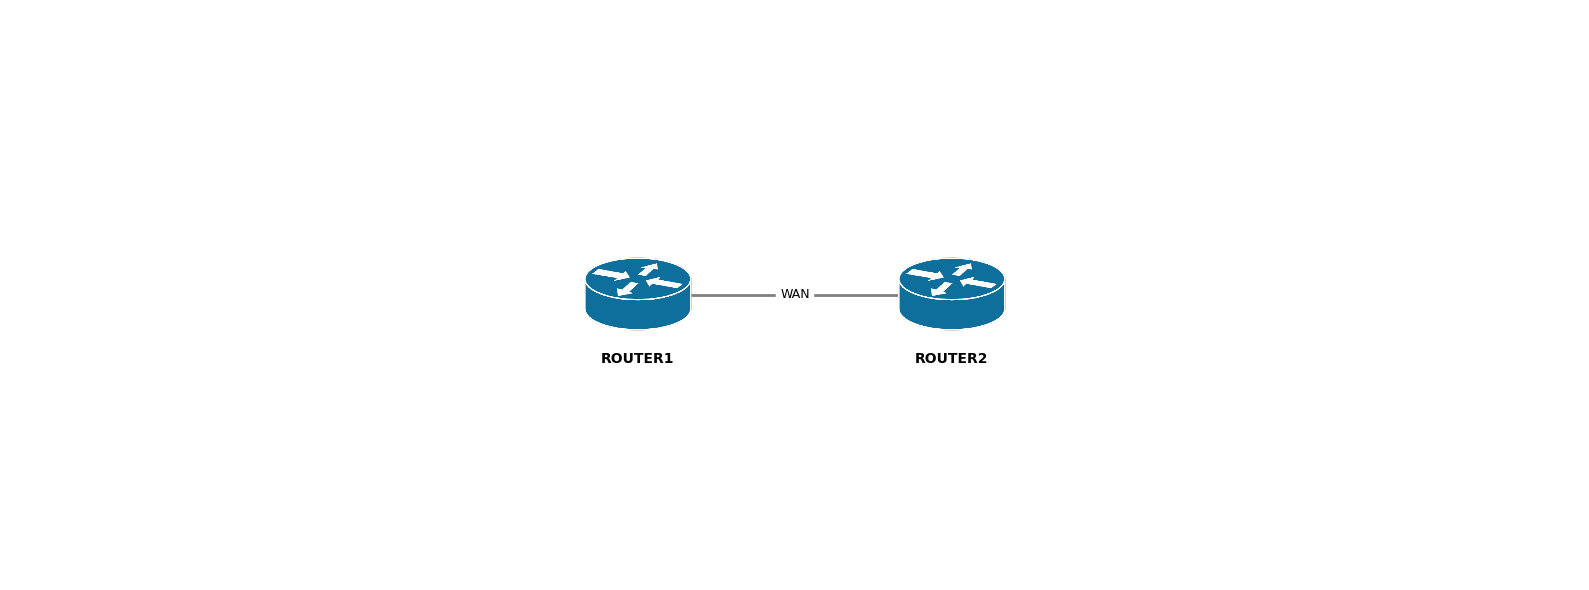

In [ ]:
create_stage_button(0, "Add Routers", "router", "info")

2025-10-28 04:06:18 [INFO] Stage 2 (Stage 2: Add Switches) initiated by user.
2025-10-28 04:06:18 [INFO] [INTERPRETER] Processing command: add switch Switch1
2025-10-28 04:06:18 [DEBUG] [LEXICAL] Matched token: ADD_SWITCH, args: ('Switch1',)
2025-10-28 04:06:18 [DEBUG] [SYNTAX] 'ADD_SWITCH' arguments OK, args=('Switch1',)
2025-10-28 04:06:18 [DEBUG] [SEMANTIC] 'ADD_SWITCH' validation OK, args=('Switch1',)
2025-10-28 04:06:18 [DEBUG] [INTERPRETER] Handler found for token 'ADD_SWITCH'
2025-10-28 04:06:18 [INFO] [EXECUTOR] Added device: name='SWITCH1', type='switch'
2025-10-28 04:06:18 [INFO] [SUCCESS] Command interpreted: 'add switch Switch1'
2025-10-28 04:06:18 [INFO] [INTERPRETER] Processing command: add switch Switch2
2025-10-28 04:06:18 [DEBUG] [LEXICAL] Matched token: ADD_SWITCH, args: ('Switch2',)
2025-10-28 04:06:18 [DEBUG] [SYNTAX] 'ADD_SWITCH' arguments OK, args=('Switch2',)
2025-10-28 04:06:18 [DEBUG] [SEMANTIC] 'ADD_SWITCH' validation OK, args=('Switch2',)
2025-10-28 04:06:18 

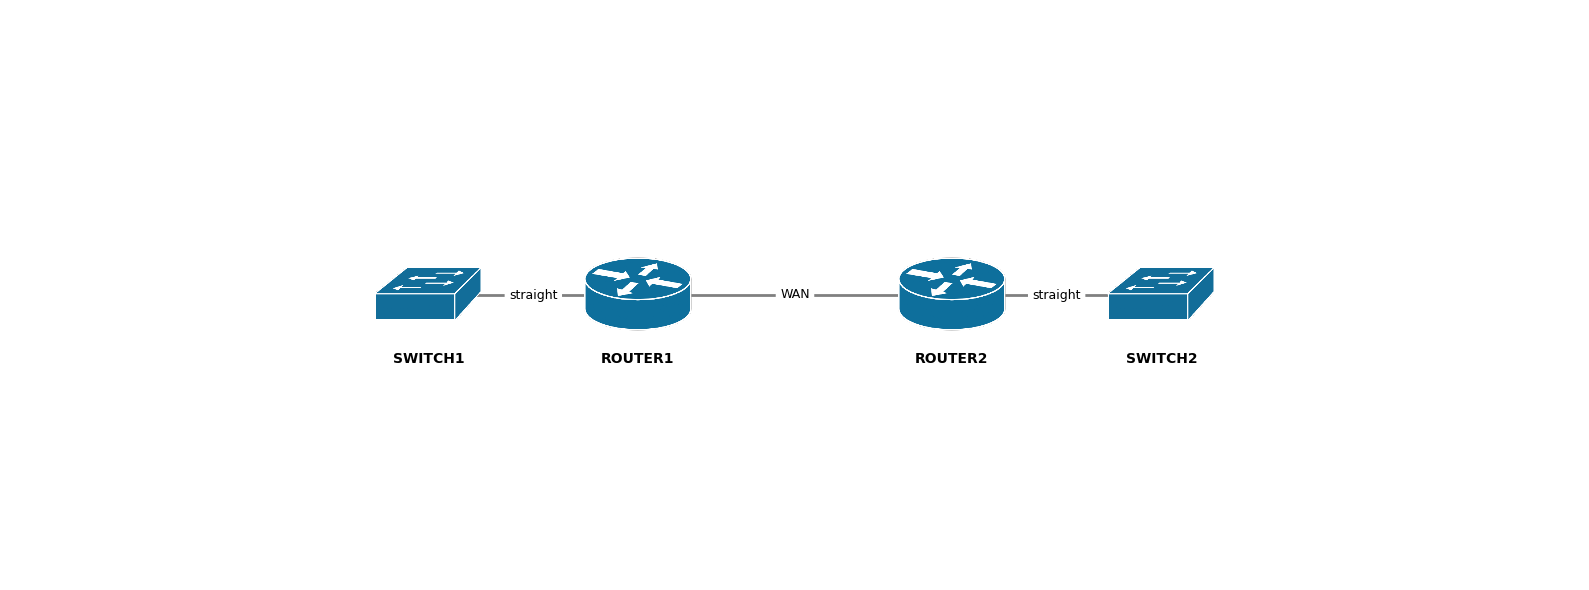

In [ ]:
create_stage_button(1, "Stage 2: Add Switches", "switch", "primary")

2025-10-28 04:06:23 [INFO] Stage 3 (Stage 3: Add Hosts) initiated by user.
2025-10-28 04:06:23 [INFO] [INTERPRETER] Processing command: add host HostA
2025-10-28 04:06:23 [DEBUG] [LEXICAL] Matched token: ADD_HOST, args: ('HostA',)
2025-10-28 04:06:23 [DEBUG] [SYNTAX] 'ADD_HOST' arguments OK, args=('HostA',)
2025-10-28 04:06:23 [DEBUG] [SEMANTIC] 'ADD_HOST' validation OK, args=('HostA',)
2025-10-28 04:06:23 [DEBUG] [INTERPRETER] Handler found for token 'ADD_HOST'
2025-10-28 04:06:23 [INFO] [EXECUTOR] Added device: name='HOSTA', type='host'
2025-10-28 04:06:23 [INFO] [SUCCESS] Command interpreted: 'add host HostA'
2025-10-28 04:06:23 [INFO] [INTERPRETER] Processing command: add host HostB
2025-10-28 04:06:23 [DEBUG] [LEXICAL] Matched token: ADD_HOST, args: ('HostB',)
2025-10-28 04:06:23 [DEBUG] [SYNTAX] 'ADD_HOST' arguments OK, args=('HostB',)
2025-10-28 04:06:23 [DEBUG] [SEMANTIC] 'ADD_HOST' validation OK, args=('HostB',)
2025-10-28 04:06:23 [DEBUG] [INTERPRETER] Handler found for token

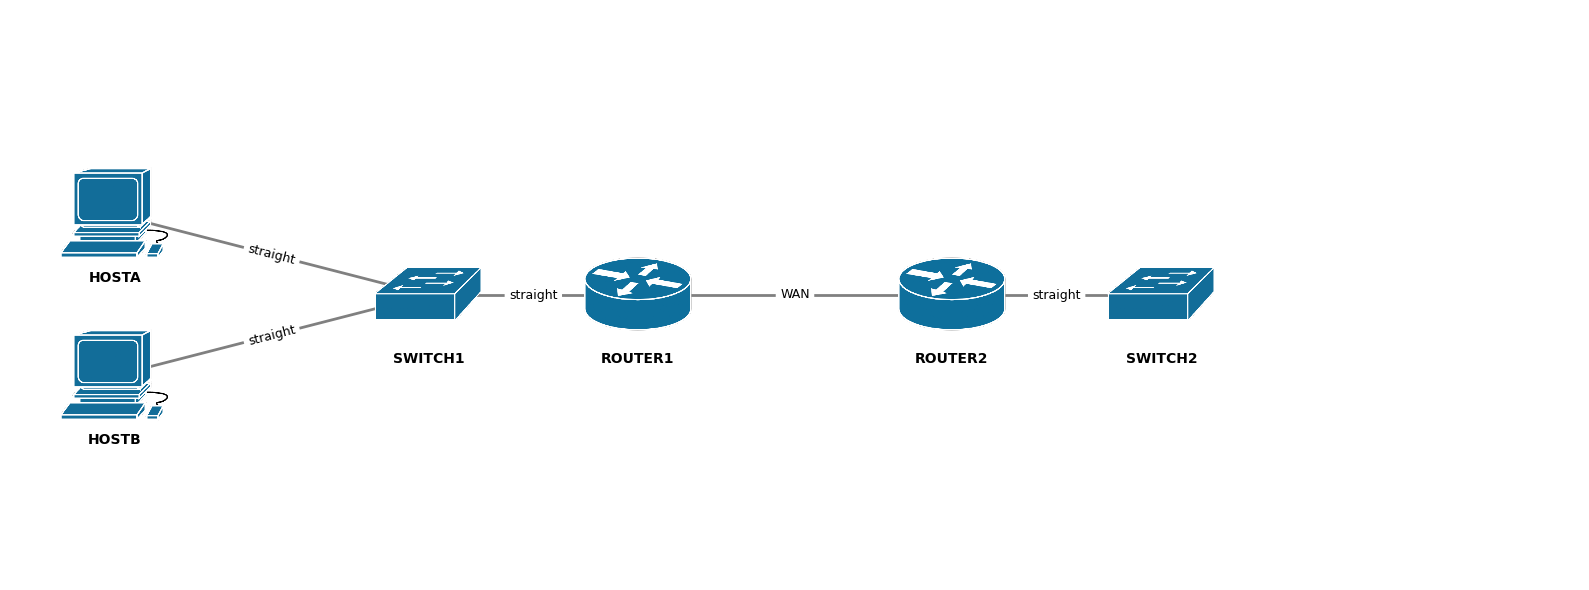

In [ ]:
create_stage_button(2, "Stage 3: Add Hosts", "host", "success")

2025-10-28 04:06:28 [INFO] Stage 4 (Stage 4: Add Servers) initiated by user.
2025-10-28 04:06:28 [INFO] [INTERPRETER] Processing command: add server ServerA
2025-10-28 04:06:28 [DEBUG] [LEXICAL] Matched token: ADD_SERVER, args: ('ServerA',)
2025-10-28 04:06:28 [DEBUG] [SYNTAX] 'ADD_SERVER' arguments OK, args=('ServerA',)
2025-10-28 04:06:28 [DEBUG] [SEMANTIC] 'ADD_SERVER' validation OK, args=('ServerA',)
2025-10-28 04:06:28 [DEBUG] [INTERPRETER] Handler found for token 'ADD_SERVER'
2025-10-28 04:06:28 [INFO] [EXECUTOR] Added device: name='SERVERA', type='server'
2025-10-28 04:06:28 [INFO] [SUCCESS] Command interpreted: 'add server ServerA'
2025-10-28 04:06:28 [INFO] [INTERPRETER] Processing command: add server ServerB
2025-10-28 04:06:28 [DEBUG] [LEXICAL] Matched token: ADD_SERVER, args: ('ServerB',)
2025-10-28 04:06:28 [DEBUG] [SYNTAX] 'ADD_SERVER' arguments OK, args=('ServerB',)
2025-10-28 04:06:28 [DEBUG] [SEMANTIC] 'ADD_SERVER' validation OK, args=('ServerB',)
2025-10-28 04:06:28 [

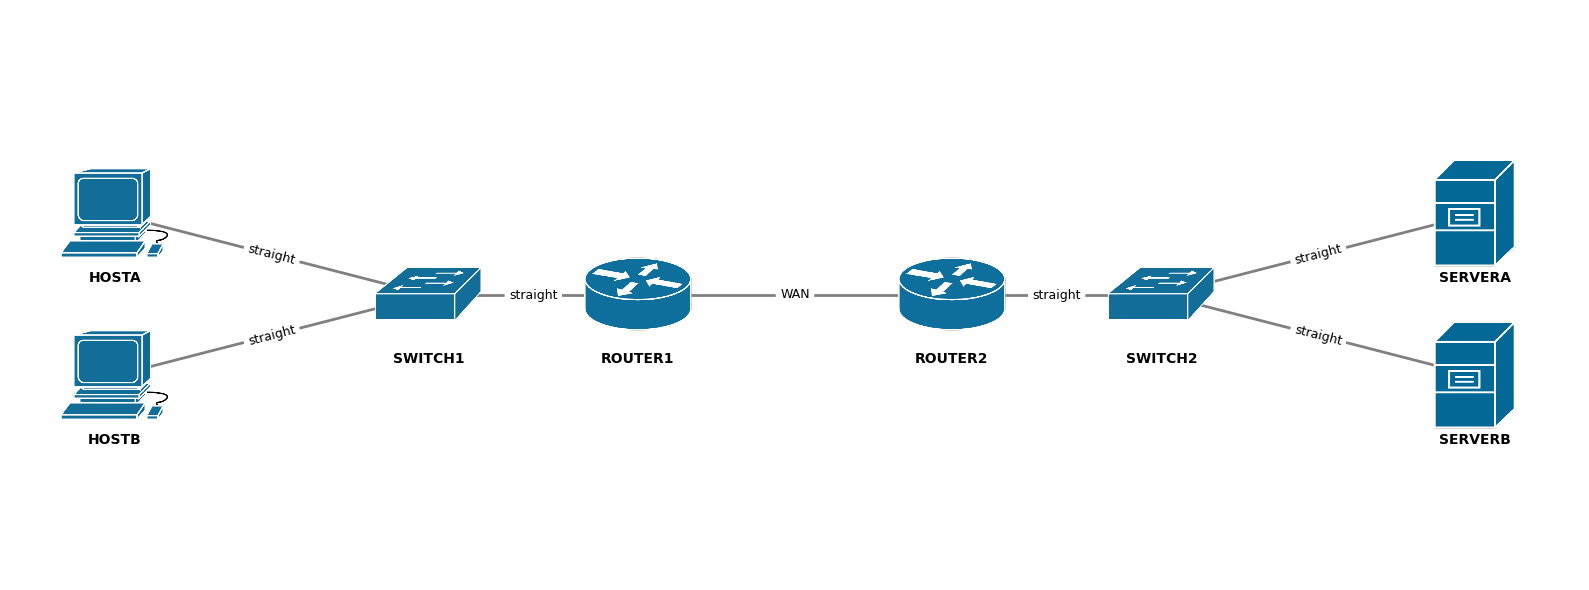

In [ ]:
create_stage_button(3, "Stage 4: Add Servers", "server", "warning")

### **6.3.1 Final Topology Setup Check**

---

Trigger the 'FINISH' command to check the current network topology.
This validates the setup, reports any missing devices or connections,
and displays the network if the setup is complete.



---



2025-10-28 04:06:32 [INFO] [INTERPRETER] Processing command: finish
2025-10-28 04:06:32 [DEBUG] [LEXICAL] Matched token: FINISH, args: ()
2025-10-28 04:06:32 [DEBUG] [SYNTAX] 'FINISH' arguments OK, args=()
2025-10-28 04:06:32 [DEBUG] [SEMANTIC] 'FINISH' validation OK, args=()
2025-10-28 04:06:32 [DEBUG] [INTERPRETER] Handler found for token 'FINISH'
2025-10-28 04:06:32 [INFO] [TOPOLOGY] Checking setup summary...
2025-10-28 04:06:32 [INFO] [SUCCESS] Network setup complete.


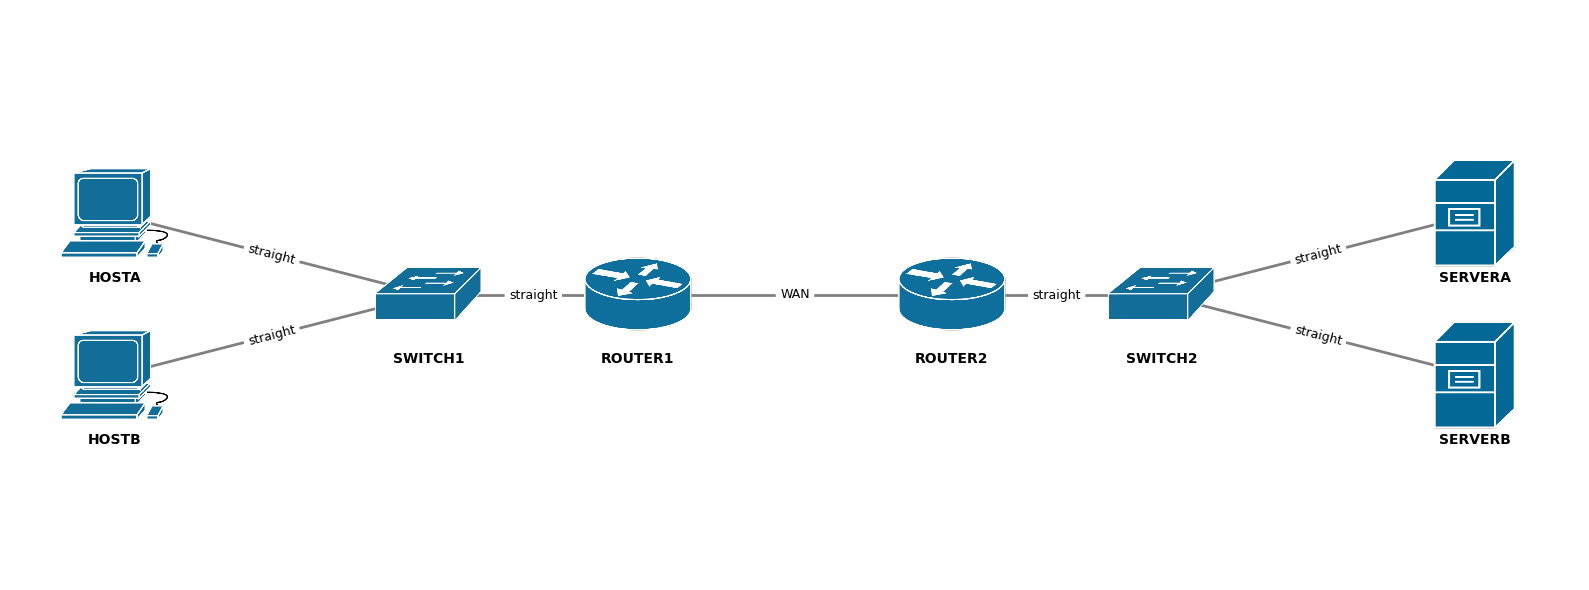

2025-10-28 04:06:32 [INFO] [SUCCESS] Command interpreted: 'finish'


In [ ]:
# Trigger the 'finish' command to verify the setup
handle_command("finish")

Define `run_interpreter_capture` function to output and review past commands using `io`, `sys`

In [ ]:
def run_interpreter_capture(sentence):
    buf = io.StringIO()
    old_stdout = sys.stdout
    sys.stdout = buf
    try:
        handle_command(sentence)
    finally:
        sys.stdout = old_stdout
    printed = buf.getvalue().strip()
    # Build CLI history and CLI full text from symbol_table["cli_commands"]
    cli_entries = symbol_table.get("cli_commands", [])
    history_lines = [entry["action"] for entry in cli_entries]
    cli_lines = []
    for entry in cli_entries:
        cli_lines.extend(entry["commands"])
    history_text = "\n".join(history_lines)
    cli_text = "\n".join(cli_lines)
    return printed, history_text, cli_text

## **6.4 Implementation via gradio**

---



Create the GUI using `gradio` for routing configurations

In [ ]:
def create_cli_gui_for_router(router_name):
    """
    Complete Gradio GUI to build CLI for a given router.
    Includes all implemented features: ACL, DHCP, RIP, EIGRP, OSPF, etc.
    """
    with gr.Blocks(
        title=f"CLI Builder - {router_name}",
        theme=gr.themes.Soft(),
        css="""
        .gradio-container {
            height: 1200px !important;
            overflow: auto;
        }
        .tab-item {
            min-height: 800px;
        }
        """
    ) as demo:
        gr.Markdown(f"# CLI Builder for {router_name}")
        gr.Markdown(
            "Buttons below generate CLI by sending sentences through the interpreter "
            "(tokenize → handlers). CLI blocks are appended to `symbol_table['cli_commands']`."
        )

        with gr.Row():
            with gr.Column(scale=2):
                history_box = gr.Textbox(
                    label="CLI Action History (human)",
                    lines=15,
                    interactive=False
                )
                cli_box = gr.Textbox(
                    label="Generated CLI (copy to Packet Tracer)",
                    lines=20,
                    interactive=True,
                    show_copy_button=True
                )

            with gr.Column(scale=1):
                # Basic Commands Tab
                with gr.Tab("Basic"):
                    gr.Markdown("### Basic Configuration")
                    btn_enable = gr.Button("Enter Privileged Mode")
                    btn_conf_t = gr.Button("Enter Global Config Mode")
                    btn_hostname = gr.Button(f"Set Hostname ({router_name})")
                    btn_save = gr.Button("Save Config")
                    btn_show_if = gr.Button("Show Interfaces")
                    btn_show_rt = gr.Button("Show Routing Table")
                    btn_clear_cli = gr.Button("Clear CLI Blocks", variant="stop")

                # Interface Configuration Tab
                with gr.Tab("Interface"):
                    gr.Markdown("### Interface Configuration")
                    iface_name = gr.Textbox(label="Interface", value="GigabitEthernet0/0")
                    iface_ip = gr.Textbox(label="IP Address", value="192.168.1.1")
                    iface_mask = gr.Textbox(label="Subnet Mask", value="255.255.255.0")
                    btn_iface = gr.Button("Configure Interface")

                # Static Routing Tab
                with gr.Tab("Static Routing"):
                    gr.Markdown("### Static Route Configuration")
                    route_net = gr.Textbox(label="Network", value="10.0.0.0")
                    route_mask = gr.Textbox(label="Mask", value="255.255.255.0")
                    route_nxt = gr.Textbox(label="Next Hop", value="192.168.1.2")
                    btn_static = gr.Button("Add Static Route")

                # OSPF Routing Tab
                with gr.Tab("OSPF"):
                    gr.Markdown("### OSPF Configuration")
                    ospf_process = gr.Textbox(label="Process ID", value="1")
                    ospf_network = gr.Textbox(label="Network", value="192.168.1.0")
                    ospf_wildcard = gr.Textbox(label="Wildcard Mask", value="0.0.0.255")
                    ospf_area = gr.Textbox(label="Area", value="0")
                    btn_ospf = gr.Button("Configure OSPF")

                # EIGRP Routing Tab
                with gr.Tab("EIGRP"):
                    gr.Markdown("### EIGRP Configuration")
                    eigrp_asn = gr.Textbox(label="AS Number", value="100")
                    eigrp_network = gr.Textbox(label="Network", value="192.168.1.0")
                    btn_eigrp = gr.Button("Configure EIGRP")

                # RIP Routing Tab
                with gr.Tab("RIP"):
                    gr.Markdown("### RIP Configuration")
                    rip_network = gr.Textbox(label="Network", value="192.168.1.0")
                    btn_rip = gr.Button("Configure RIP")

                # DHCP Configuration Tab
                with gr.Tab("DHCP"):
                    gr.Markdown("### DHCP Pool Configuration")
                    dhcp_pool = gr.Textbox(label="Pool Name", value="LAN_POOL")
                    dhcp_network = gr.Textbox(label="Network", value="192.168.1.0")
                    dhcp_mask = gr.Textbox(label="Mask", value="255.255.255.0")
                    dhcp_gw = gr.Textbox(label="Default Gateway", value="192.168.1.1")
                    dhcp_dns = gr.Textbox(label="DNS Server", value="8.8.8.8")
                    btn_dhcp = gr.Button("Configure DHCP")

                # ACL Configuration Tab
                with gr.Tab("ACL"):
                    gr.Markdown("### Access Control Lists")

                    with gr.Row():
                        with gr.Column():
                            gr.Markdown("#### Standard ACL")
                            acl_std_num = gr.Textbox(label="ACL Number", value="1")
                            acl_std_action = gr.Dropdown(
                                choices=["permit", "deny"],
                                label="Action",
                                value="permit"
                            )
                            acl_std_src = gr.Textbox(label="Source Network", value="192.168.1.0 0.0.0.255")
                            btn_acl_std = gr.Button("Add Standard ACL Rule")

                        with gr.Column():
                            gr.Markdown("#### Extended ACL")
                            acl_ext_num = gr.Textbox(label="ACL Number", value="100")
                            acl_ext_action = gr.Dropdown(
                                choices=["permit", "deny"],
                                label="Action",
                                value="permit"
                            )
                            acl_ext_proto = gr.Dropdown(
                                choices=["ip", "tcp", "udp", "icmp"],
                                label="Protocol",
                                value="ip"
                            )
                            acl_ext_src = gr.Textbox(label="Source", value="any")
                            acl_ext_dst = gr.Textbox(label="Destination", value="any")
                            btn_acl_ext = gr.Button("Add Extended ACL Rule")

        # Callback function
        def update_from_sentence(sentence, hist_text, cli_text):
            printed, history_text, cli_text_new = run_interpreter_capture(sentence)
            return history_text, cli_text_new if cli_text_new else printed

        # Basic button events
        btn_enable.click(lambda h,c, s="enable": update_from_sentence(s, h, c),
                         [history_box, cli_box], [history_box, cli_box])
        btn_conf_t.click(lambda h,c, s="configure terminal": update_from_sentence(s, h, c),
                         [history_box, cli_box], [history_box, cli_box])
        btn_hostname.click(lambda h,c, s=f"set hostname {router_name} {router_name}": update_from_sentence(s, h, c),
                           [history_box, cli_box], [history_box, cli_box])
        btn_save.click(lambda h,c, s=f"save {router_name}": update_from_sentence(s, h, c),
                       [history_box, cli_box], [history_box, cli_box])
        btn_show_if.click(lambda h,c, s=f"show interfaces {router_name}": update_from_sentence(s, h, c),
                          [history_box, cli_box], [history_box, cli_box])
        btn_show_rt.click(lambda h,c, s=f"show routing {router_name}": update_from_sentence(s, h, c),
                          [history_box, cli_box], [history_box, cli_box])
        btn_clear_cli.click(lambda h,c, s="clear cli": update_from_sentence(s, h, c),
                            [history_box, cli_box], [history_box, cli_box])

        # Interface button event
        btn_iface.click(lambda i, ip, m, h, c, rn=router_name: update_from_sentence(f"set interface {rn} {i} {ip} {m}", h, c),
                        [iface_name, iface_ip, iface_mask, history_box, cli_box], [history_box, cli_box])

        # Static routing button event
        btn_static.click(lambda n, m, nxt, h, c, rn=router_name: update_from_sentence(f"set static-route {rn} {n} {m} {nxt}", h, c),
                         [route_net, route_mask, route_nxt, history_box, cli_box], [history_box, cli_box])

        # OSPF button event
        btn_ospf.click(lambda proc, net, wild, area, h, c, rn=router_name:
                       update_from_sentence(f"set ospf {rn} {proc} {net} {wild} {area}", h, c),
                       [ospf_process, ospf_network, ospf_wildcard, ospf_area, history_box, cli_box],
                       [history_box, cli_box])

        # EIGRP button event
        btn_eigrp.click(lambda asn, net, h, c, rn=router_name:
                        update_from_sentence(f"set eigrp {rn} {asn} {net}", h, c),
                        [eigrp_asn, eigrp_network, history_box, cli_box],
                        [history_box, cli_box])

        # RIP button event
        btn_rip.click(lambda net, h, c, rn=router_name:
                      update_from_sentence(f"set rip {rn} {net}", h, c),
                      [rip_network, history_box, cli_box],
                      [history_box, cli_box])

        # DHCP button event
        btn_dhcp.click(lambda pool, net, mask, gw, dns, h, c, rn=router_name:
                       update_from_sentence(f"set dhcp {rn} {pool} {net} {mask} {gw} {dns}", h, c),
                       [dhcp_pool, dhcp_network, dhcp_mask, dhcp_gw, dhcp_dns, history_box, cli_box],
                       [history_box, cli_box])

        # ACL button events
        btn_acl_std.click(lambda num, action, src, h, c, rn=router_name:
                          update_from_sentence(f"set acl-std {rn} {num} {action} {src}", h, c),
                          [acl_std_num, acl_std_action, acl_std_src, history_box, cli_box],
                          [history_box, cli_box])

        btn_acl_ext.click(lambda num, action, proto, src, dst, h, c, rn=router_name:
                          update_from_sentence(f"set acl-ext {rn} {num} {action} {proto} {src} {dst}", h, c),
                          [acl_ext_num, acl_ext_action, acl_ext_proto, acl_ext_src, acl_ext_dst, history_box, cli_box],
                          [history_box, cli_box])

    return demo

Define `launch_cli_builder_for_all_routers` function to run gradio GUI


> Function attempts to check `devices: {}` if devices exists before running GUI, otherwise return an error message.


In [ ]:
def launch_cli_builder_for_all_routers(share=False):
    routers = [d for d, t in symbol_table["devices"].items() if t == "router"]
    if not routers:
        print("No routers found. Build topology first (use Stage buttons).")
        return
    demos = []
    for r in routers:
        demos.append((create_cli_gui_for_router(r), r))
    if len(demos) == 1:
        demos[0][0].launch(share=share, height=1000)
    else:
        with gr.Blocks() as combined:
            gr.Markdown("# Multi-Router CLI Builder")
            with gr.Tabs():
                for demo, r in demos:
                    with gr.Tab(r):
                        demo.render()
        combined.launch(share=share, height=1000)

In [ ]:
launch_cli_builder_for_all_routers(share=False)

No routers found. Build topology first (use Stage buttons).


# ***Section 7: Extensions and Additional Features***

---



Beyond the core interpretation pipeline, our system includes several **extended features** that enhance its usability and realism. One major extension is the integration of a comprehensive **logging system** using Python’s logging module. It records each phase of execution—from lexical analysis to interpretation—with timestamps and color-coded log levels for better traceability. This logging framework not only aids in debugging and monitoring command execution but also provides clear insights into system performance and user actions.

Another vital enhancement is the **Command Handler Registry** implemented through Python decorators (`@command_handler`), which allows new commands to be easily added without modifying the core parser. This makes the interpreter highly extensible and maintainable, encouraging modular growth as more network functions are introduced.

Another enhancement is the **integration of a CLI command history** via the `symbol_table`, which stores all executed configuration steps. This feature enables the interpreter to avoid duplicate command executions and supports clear visualization of applied configurations. Additionally, the interpreter includes **topology visualization** using `networkx` and `matplotlib`, allowing users to see real-time graphical representations of connected devices and links.

Together, these extensions significantly improve the interpreter’s usefulness by combining **realistic command behavior**, **visual feedback**, and **expandable functionality**, transforming it from a simple text processor into a flexible and interactive network simulation tool.

# ***Section 8: Insights and Conclusions***

---



Through the development of this network topology and CLI command interpreter, it was found that the machine project is successful at inputting Cisco devices via static declaration. Another key factor was outputting Cisco commands from gradio buttons with descriptive labels exhibiting a beginner-friendly atmosphere for new users attempting to learn Cisco Packet Tracer. In coherence, the interpreter does not simply implicate the utilization of static declaration, however it also allows users to enter their IP addresses and subnet addresses which are validated within the command-processing pipeline as it also serves as a sandbox for trial and error. Furthermore, the project enhanced understanding of interpreter design, particularly the coordination between lexical, syntactic, and semantic analysis in achieving accurate command execution and modular system architecture.



## **8.1 Final Assessment and Further Exploration**

---



Future projects that correlate to improving the state of allowing new users to learn should explore fields that are deeply related in deep learning via neural networks for Natural Language Processing (NLP). This project was limited to defining under a table aside from training a neural network was not feasible given the time constraint and scarcity of finding appropriate datasets for model training.

# ***Section 9: References***

---



Name of Tools Used:

* ChatGPT 4.0 (OpenAI)

* Claude (Anthropic)

###**9.1 Prompts**
---

- "What are the fundamentals of a robust and scalable compiler?"
- "How can we handle exceptions gracefully?"
- "What design principles could we implement to make it modular and easy to use"
- "How can we utilize this Python documentation and implement it on our interpreter system?"

### **9.2 Documentation**
---

Documentation References:

* CPython InternalDocs – Compiler. <br>
Available at: https://github.com/python/cpython/blob/main/InternalDocs/compiler.md

* Python Logging Library Documentation. <br>
Available at: https://docs.python.org/3/library/logging.html

* Python Tutorial – Errors and Exceptions (Handling Exceptions Section). <br>
Available at: https://docs.python.org/3/tutorial/errors.html#handling-exceptions

* The Decorator Pattern — Python Design Patterns Guide. <br>
Available at: https://python-patterns.guide/gang-of-four/decorator-pattern/

* PEP 318 – Decorators for Functions and Methods. <br>
Available at: https://peps.python.org/pep-0318/

* Wittenauer, J. *NetworkX Library Tutorial (Google Colab Notebook)*. <br>
Available at: https://colab.research.google.com/github/jdwittenauer/ipython-notebooks/blob/master/notebooks/libraries/NetworkX.ipynb

* ipywidgets Official Documentation. <br>
Available at: https://ipywidgets.readthedocs.io/en/stable/reference/ipywidgets.html

* Widget Basics and Widget List. <br>
Available at: https://ipywidgets.readthedocs.io/en/stable/examples/Widget%20Basics.html

* Gradio Blocks API Documentation. <br>
Available at: https://www.gradio.app/docs/gradio/blocks
